In [2]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-x5dqh5_2
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-x5dqh5_2
  Resolved https://github.com/facebookresearch/detectron2.git to commit 9604f5995cc628619f0e4fd913453b4d7d61db3f
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 32.9 MB/s eta 0:00:0000:01
  Created wheel for detectron2: filename=detectron2-0.6-cp310-cp310-linux_x86_64.whl size=5974735 sha256=2fa159d5fbf8fa077121d5499af6ad1704ca7c0f341cbd3246928071b444cebf
  Stored in directory: /tmp/pip-ephem-wheel-cache-cqsh86fz/wheels/47/e5/15/94c80df2ba85

In [3]:
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo


Cloning into 'detectron2_repo'...
remote: Enumerating objects: 15837, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 15837 (delta 35), reused 14 (delta 14), pack-reused 15772 (from 2)
Receiving objects: 100% (15837/15837), 6.41 MiB | 21.24 MiB/s, done.
Resolving deltas: 100% (11533/11533), done.


In [4]:
import torch
import cv2
import numpy as np
import detectron2
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.model_zoo import get_config_file, get_checkpoint_url

In [5]:
cfg = get_cfg()
cfg.merge_from_file(get_config_file("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Set a threshold for detection
cfg.MODEL.WEIGHTS = "/kaggle/input/detectron2_building_instance_segmentation/pytorch/default/1/instance_segmentation_building.pth" # path to the model we just trained
cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"  # Use GPU if available
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7 # set a custom testing threshold

In [6]:
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

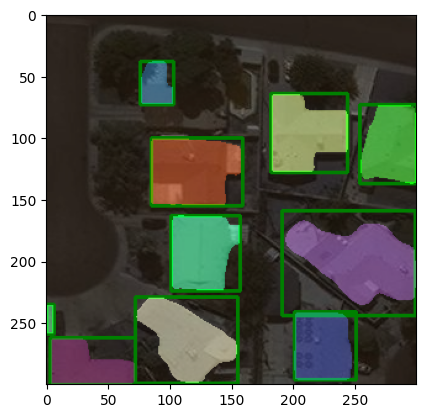

In [7]:
image_path = "/kaggle/input/test-data-building/000000000030.jpg"
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

predictor = DefaultPredictor(cfg)
outputs = predictor(image_rgb)

instances = outputs["instances"].to("cpu")

pred_boxes = instances.pred_boxes.tensor.numpy()
pred_masks = instances.pred_masks.numpy()
pred_classes = instances.pred_classes.numpy()
scores = instances.scores.numpy()

mask_overlay = np.zeros_like(image, dtype=np.uint8)

# Generate random colors for each mask
num_instances = len(pred_masks)
colors = np.random.randint(0, 255, (num_instances, 3), dtype=np.uint8)

for i in range(num_instances):
    x1, y1, x2, y2 = map(int, pred_boxes[i])
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    
    mask = pred_masks[i]  # Get the binary mask (True/False)
    color = colors[i].tolist()

    # Apply the mask color to the overlay
    mask_overlay[mask] = color

# Blend the original image and the mask overlay
alpha = 0.5  # Transparency factor
blended = cv2.addWeighted(image, 1 - alpha, mask_overlay, alpha, 0)

plt.imshow(blended)
plt.show()